In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re
import pandas as pd
import numpy as np
from tqdm import tqdm 

from bs4 import BeautifulSoup as soup
import Levenshtein as L

In [3]:
data = pd.read_csv('raw_digilib.tsv', sep='\t', index_col=0)
data.tail()

,dc:title,dc:creator,dc:contributor,dc:nidn,dc:subject,dc:date,dc:language,dc:type,dc:Keyword,dc:Institution,dc:description
51861,PELACAKAN OBJEK DAN PENGAMBIL GAMBAR WAJAH PAD...,"Dasa Nanda Putra, Rafi","Dr. Ir. Mervin Tangguar Hutabarat, M.Sc.;Muham...",0018056501;0023108802,STEI - Teknik Elektro,2020-11-03 13:32:09,Indonesia,Thesis,"Kriminalitas, Pencacahan, Pendeteksian, Pengen...",INSTITUTE TEKNOLOGI BANDUNG,Tingginya angka kriminalitas di Indonesia teru...
51862,METODE KETERLIBATAN STAKEHOLDER UNTUK IMPLEMEN...,"Maheswari, Hesti","Ir. Gatot Yudoko, M.A.Sc., Ph.D.;Akbar Adhi Ut...",0025076102;0005067707,SBM - Sains Manajemen,2020-11-20 14:48:01,Indonesia,Thesis,"metode keterlibatan, sustainable reverse logis...",INSTITUTE TEKNOLOGI BANDUNG,Pengolahan sampah elektronik di Indonesia dido...
51863,EVALUASI TARIF PDAM KOTA BANDUNG BERDASARKAN P...,"Ajeng Koesoemo Roekmi, Raden","Ir. Widiarto, MCRP., Ph.D;",NaN,SAPPK - Perencanaan Wilayah dan Kota,2020-11-21 16:18:38,Indonesia,Thesis,"Prinsip Keterjangkauan, Prinsip Keadilan, Stan...",INSTITUTE TEKNOLOGI BANDUNG,Penyediaan air bersih oleh Pemerintah Daerah h...
51864,DAMPAK KINERJA USAHA MIKRO KECIL DAN MENENGAH ...,"Ahmad Muzakky, Faqih","Dr. Ir. Subiakto, M.B.A.;",0014046017,SBM - Sains Manajemen,2020-11-24 13:36:51,Indonesia,Thesis,"inklusi keuangan, UMKM, e-commerce",INSTITUTE TEKNOLOGI BANDUNG,Sebuah pertanyaan telah banyak diangkat dalam ...
51865,USULAN STRATEGI USAHA PERUSAHAAN KONSULTAN ITB...,"Fitriani, Novi","Deddy Priatmodjo Koesrindartoto, Ph.D.;",0003047006,Magister Bisnis dan Administrasi - Teknologi,2020-11-27 15:23:57,Indonesia,Thesis,"Strategi Bisnis, Akuisisi, Peningkatan Keuanga...",INSTITUTE TEKNOLOGI BANDUNG,Institut Teknologi Bandung (ITB) merupakan per...


## Cleaning Data

In [4]:
def cleanstr(x):
    return ' '.join(soup(x).get_text().split())

### Buang kolom yang redundan

In [5]:
for col in data:
    print('{:<15} {:>5}'.format(col, len(set(data[col]))))

dc:title        47494
dc:creator      47697
dc:contributor  28516
dc:nidn          3017
dc:subject        104
dc:date         33809
dc:language         1
dc:type             1
dc:Keyword      44706
dc:Institution      1
dc:description  46303


In [6]:
data.drop(['dc:language', 'dc:type', 'dc:Institution'],
          axis=1, inplace=True)

### Rename kolom (hilangkan `dc:`)

In [7]:
# mapper = {x:x[3:] for x in items}
mapper = {'dc:title': 'title',
         'dc:creator': 'creator',
         'dc:contributor': 'contributor',
         'dc:nidn': 'nidn',
         'dc:subject': 'subject',
         'dc:date': 'date',
         'dc:Keyword': 'keyword',
         'dc:description': 'description'}

data = data.rename(columns=mapper)

### Ada apa di kolom `title`?

In [8]:
%%time

data['title'] = data['title'].apply(cleanstr)
data['title'] = data['title'].apply(lambda x:'' if len(x)<6 else x)

CPU times: user 35.8 s, sys: 459 ms, total: 36.3 s
Wall time: 36.4 s


### Ada apa di kolom `creator`?

dari analisis yang pernah dilakukan pada versi kedua notebook ini, terlihat bahwa data creator pernah mengandung data NIM -- mungkin karena suatu kebijakan. Sayangnya, kebijakan hal ini tidak dilanjutkan. Mengingat mendapatkan data NIM dari nama lengkap tidak sulit, kali ini saya memilih untuk menghapus data NIM tersebut

In [9]:
def fixing_cell(text):
    
    # anggap data dengan len<5 sebagai NaN
    if len(text)<5: return ''
        
    # hilangkan (...)
    text = re.sub('\([ :\w.-]*\)', '', text)
    
    # hilangkan http...
    text = re.sub('http[^ ]*', '', text)

    # hilangkan ...@...
    text = re.sub('[^ ]*@[^ ]*', '', text)
    
    # hilangkan ...-...-...
    text = re.sub('\w[0-9]*-[0-9]*-[0-9]*\w', '', text)
    
    # hilangkan NIM
    text = re.sub('[0-9]{8}', '', text)
    
    # rapikan penulisan simbol-simbol lain
    text = re.sub(u'\u0305', '', text)
    
    # rapikan penulisan nama
    if text.count(',')==1:
        a, b = text.split(',')
        text = b + ' ' + a

    # hapus info pembimbing
    if 'pembimbing' in text.lower():
        idx = text.lower().find('pembimbing')
        text = text[:idx]

    # hapus info nim
    if 'nim' in text.lower():
        idx = text.lower().find('nim')
        text = text[:idx]

    text = text.strip()
    if text and not text[-1].isalpha():
        text = text[:-1]
        
    return text.strip().title()

In [10]:
%%time

data['creator'] = data['creator'].apply(cleanstr)
data['creator'] = data['creator'].apply(fixing_cell)

CPU times: user 36.2 s, sys: 372 ms, total: 36.6 s
Wall time: 36.6 s


In [11]:
data['creator'].sample(10).tolist()

['Teuku Muhammad Nafis Barizki',
 'Gea Oswah Fatah Parikesit',
 'Nur Ramadhani, Arry Akhmad Arman, Kurniawan',
 'Nurfitriansyah',
 'Akhmad Zaenudin',
 'Istriyati',
 'Subakti',
 'Keithcar Llang Mayo',
 'Fajar Feriansyah',
 'Henry Irawan']

### Ada apa di kolom `contributor`?

In [12]:
# ubah NaN sebagai string kosong
data['contributor'].fillna('', inplace=True)

In [13]:
data['contributor'].sample(10).tolist()

['Pembimbing : Drs. Yan Yan Sunarya, M.Sn.',
 'Dr. Qomarudin Helmy, S.Si., M.T.;',
 'Dr. Yudi Darma, S.Si., M.Si.;',
 'Pembimbing: Dr. I Made Arcana',
 'Ir. Agus Jatnika Effendi,Ph.D',
 'Pembimbing 1<br>Tutuka Ariadji, Ir., M.Sc.Ph.D.<p>Pembimbing 2<br>Pudjo Sukarno, Ir., M.Sc., Ph.D.<p>Scan:<br>Hidayat (2006-03-13)',
 'Ir. Made Suarjana, M.Sc., Ph.D.;',
 'Pembimbing : Dr.-Ing.Ir. Aryo P. Wibowo, M.Eng',
 'Jing-Feng Gao.,Xiao-Yan Fan.,Ding-Chang L.,Hui-Hui Dai',
 'Ir. Toto Indriyanto, M.Sc., Ph.D.;Ony Arifianto, Ph.D.;']

Selanjutnya, saya memilih untuk merapikan data kontributor agar sebisa mungkin hanya berisi nama lengkap kontributor. Walaupun data jabatan kontributor dapat digunakan dalam penelitian, penulisannya yang tidak konsisten cukup mengganggu. Begitu pula dengan pranala, alamat surel, maupun nomor telpon yang kadang dicantumkan dalam kolom ini.

```python
# pseudocode menghapus gelar dari string
wordlist = string.split()

pruned = []
for word in wordlist:
    if levenstein_distance(word, daftar_gelar) < threshold:
        # jangan dimasukkan
        pass
    else:
        pruned.append(word)
        
return ' '.join(pruned)
```

In [14]:
# data dari:
#   https://www.kitapunya.net/daftar-singkatan-gelar-sarjana/
#   http://sonny-tobelo.blogspot.com/2013/07/gelar-gelar-akademik.html

replace = {'Pembimbing', 'Prof.', 'Scanner', 'S.Ked.', 'S.Kep.', 'S.K.M.', 'S.Gz.', 'S. Farm.', 'S.Pt.', 'S.I.P.', 'S.IP.', 'S.E.', 'S.E.I.', 'S.E.', 'S.E', 'S.Kom.', 'S.H.', 'S. AB.', 'S.T.', 'S.T.', 'S.T.', 'S.T.P.', 'S.Pd.', 'S.Pd.SD.', 'S.Pd.I.', 'S.Ked.', 'SKG.', 'S.Pd.', 'S.Psi.', 'S.Sos.', 'S.I.Kom.', 'S.S.', 'S.AP.', 'S.P.', 'S.Si', 'S.STP.', 'S.Fhil.', 'S.Fil.I', 'S.Ag.', 'S.Sn.', 'S.Th.I.', 'S.Th.K', 'S.H.I.', 'S.Pi.', 'S.Si.', 'S.Si.', 'S.Kel.', 'S.Kom.', 'S.SI.', 'S.Hum', 'S.Agr.', 'S.Hut.', 'S.Sy.', 'M.Ag.', 'M.A.Ked.', 'M.A.Pd.', 'M.A.Hum.', 'M.Hut.', 'MA.', 'M.P.H.', 'M.Cs.', 'M.M.', 'M.Si.', 'M.TI.', 'M.Kom.', 'M.Pd.', 'MMSI.', 'M.Ak.', 'M.Sn.', 'M.A.R.S.', 'M.Kn.', 'M.Psi.', 'M.Farm.', 'M.Farm.Klin.', 'M.MPd.', 'M.Hum.', 'M.T.', 'MSA.', 'M.S.M.', 'M.S.E.', 'M.Si.Han', 'MSEE.', 'M.Econ.', 'M.E.I.', 'M.E.Sy.', 'MSIE.', 'M.AP.', 'M.A.Pd.', 'M.AB.', 'M.A.R.S.', 'M.H.', 'M.H.Kes.', 'M.Stat.', 'M.P.', 'M.Kes.', 'M.H.I.', 'M.Fhil.', 'M.Fil.I.', 'M.Pd.I.', 'M.Si.', 'M.Si.', 'M.A.', 'M.Kesos.', 'M.Han.', 'M.I.Kom.', 'M.I.Pol.', 'M.Keb.', 'M.Ked.Trop.', 'M.K.K.', 'M.T.', 'M.T.', 'M.T.', 'M.T.', 'M.T.A', 'M.Sos.I.', 'M.S.I.', 'M.Kes.', 'M.Agri.', 'M.Ars.', 'M.Ds.', 'M.Biomed.', 'M.Div.', 'M.Epid.', 'M.Kor.', 'M.Tr.Hanla.', 'M.Tr.', 'M.Th', 'M.Min', 'M.P.Mat.', 'M.P.Kim.', 'M.P.Kim', 'M.P.I.', 'M.Mar', 'M.Li.', 'Dr.', 'Dr.', 'Dr.', 'Dr.', 'Dr.', 'A.P.', 'A.P.Par.', 'A.P.Kom.', 'A.Ma.', 'A.Ma.Pd.', 'A.Ma.Pust.', 'A.Md.Far.', 'A.Md.Keb.', 'A.Md.', 'A.Md.Pd.', 'A.Md.Per.', 'A.Md.Par.', 'A.Md.Bid.', 'A.Md.Kes.', 'A.Md.Ak.', 'A.Md.Kom.', 'A.Md.K.G.', 'A.Md.', 'Drs.', 'Dra.', 'Ir.', 'A.P', 'A.Ma', 'A.Md', 'A', 'A.Ma.Pd', 'A.Md.Per', 'A.Md.Kes', 'A.Md.Bid', 'A.Md.Par', 'Drs', 'Dra', 'Ir', 'S.Ag', 'S.Pd', 'S.Si', 'S.Psi', 'S.Hum', 'S.Kom', 'S.Sn', 'S.Pt', 'S.Ked', 'S.Th.I', 'S.Kes', 'S.Sos', 'S.Kar', 'S.Fhil', 'S.T', 'S.P', 'S.S', 'S.H', 'S.E', 'S.Th.K', 'S.I.P', 'S.K.M', 'S.H.I', 'S.Sos.I', 'S.Fil.I', 'S.Pd.I', 'S.KG', 'S.TP', 'S.Pi', 'S.Hut', 'S.KH', 'S.Ars', 'S.Ds', 'SEi', 'S.Farm', 'S.Apt', 'S.Gz', 'S.In', 'S.Kel', 'S.IKom', 'S.Ners', 'S.Kep', 'S.Mn', 'S.Pd.SD', 'S.S.T', 'S.si', 'B.A', 'B.Sc', 'B.Ag', 'B.E', 'B.D', 'B.Litt', 'B.M', 'B.Arch', 'L.L.B', 'BIE', 'Bc,Kn', 'BBA', 'B.Com', 'B.Bus', 'B.Eng', 'Dipl. Ing', 'M.Hum', 'M.M', 'M.Si', 'M.Kes', 'M.P', 'M.Kom', 'M.Sn', 'M.Pd', 'M.Ag', 'M.T', 'MMSI', 'M. Kn', 'MKKK', 'MSA', 'M.Kes', 'M.Ked', 'M.Kesja', 'MMR', 'MARS', 'MKK', 'MKK', 'M.A', 'M.Sc', 'M.Eng', 'M.B.A', 'M.Th', 'Th.M', 'L.L.M', 'M.Mgt', 'M.Comp.Sc', 'M.App.Sc', 'M.Arch', 'MSIE', 'M.Econ', 'M.Eng.Sc', 'M.S', 'Mbus', 'M.Ed', 'M.Litt', 'M.Lib', 'M.Mus', 'M.Nurs', 'M.F', 'M.F.A', 'M.R.E', 'M.S', 'M.P.H', 'MComm or Mcom', 'Dr', 'Dr.H.C', 'M.Phil', 'Ph.D', 'Th.D', 'Ed.D', 'D.Comm', 'D.Eng', 'D.Sc', 'D.Econ', 'DBA', 'Pharm.D', 'D.P.H', 'D.L.S', 'D.M.D', 'J.S.D'}

# "kata" yang pasti perlu dihapus
wrong = {'1', '2', '3', '=', 'dan', '#CONTRIBUTOR#'}

# untuk mempersingkat waktu fungsi is_equal
cache = {}

# untuk mengecek apakah sebuah kata mirip dengan gelar
# kita gunakan levenstein distance. semakin mirip penulisan
# kedua kata, semakin kecil distancenya
def is_equal(word, threshold = 2):
    if word in cache: return cache[word]
    
    for r in replace:
        if L.distance(r, word) < threshold:
            cache[word] = True
            return True
    return False

# hal-hal lain yang perlu dirapikan dari data
def fixing_cell(text):
    
    # anggap data dengan len<5 sebagai NaN
    if len(text)<5: return ''

    # hilangkan (...)
    text = re.sub('\([ \w.-]*\)', '', text)
    
    # hilangkan http...
    text = re.sub('http[^ ]*', '', text)

    # hilangkan ...@...
    text = re.sub('[^ ]*@[^ ]*', '', text)
    
    # hilangkan ...-...-...
    text = re.sub('\w[0-9]*-[0-9]*-[0-9]*\w', '', text)
    
    # rapikan penulisan simbol-simbol lain
    text = re.sub(u'\u0305', '', text)
    text = re.sub('[;:,]+', ' = ', text)
    
    res = []
    for w in text.split():
        if (w in wrong) or is_equal(w):
            res.append('')
        elif res:
            res[-1] += ' ' + w
        else:
            res.append(w)

    if not res: return ''
    return ', '.join([w.strip() for w in res if w])

In [15]:
%%time

data['cont'] = data['contributor'].apply(cleanstr)
data['contributor'] = data['cont'].apply(fixing_cell)

CPU times: user 1min 20s, sys: 367 ms, total: 1min 21s
Wall time: 1min 21s


In [16]:
for x, y in data[['cont', 'contributor']].sample(5).values:
    print('orig: {}\nprun: {}\n'.format(x, y))

orig: Pembimbing : Prof. Dr. Ir. Ketut Wikantika, M.Eng.
prun: Ketut Wikantika

orig: Udjianna Sekteria Pasaribu, Ph.D.;Dr. RR. Kurnia Novita Sari, S.Si., M.Si.;
prun: Udjianna Sekteria Pasaribu, RR. Kurnia Novita Sari

orig: Prof. Dr. Ir. Dradjad Irianto, M. Eng. ;Fariz Muharram Hasby, S.T, M.T.
prun: Dradjad Irianto, Eng., Fariz Muharram Hasby

orig: Pembimbing: Agus S. Ekomadyo, ST., MT., Dr.; Dr. Ir. Baskoro Tedjo, MSEB
prun: Agus, Ekomadyo, Baskoro Tedjo, MSEB

orig: Pembimbing: Dr.rer.nat. Wiwin Windupranata, ST, M.Si., dan Dwi Haryanto, ST.
prun: Dr.rer.nat. Wiwin Windupranata, Dwi Haryanto



In [17]:
data.drop('cont', axis=1, inplace=True)

### Ada apa di kolom `subject`?

In [18]:
# ubah NaN sebagai string kosong
data['subject'].fillna('', inplace=True)

In [19]:
def fakultas(subjek):
    if '-' in subjek:
        tmp = sorted(subjek.split('-'), key=len)
        if tmp[0].isupper(): 
            return tmp[0].strip()
        else:
            return ''
    return ''

In [20]:
def prodi(subjek):
    if '-' in subjek:
        tmp = sorted(subjek.split('-'), key=len)
        return tmp[1].strip()
    else:
        return subjek

In [21]:
%%time

data['subject'] = data['subject'].apply(cleanstr)

data['fakultas'] = data['subject'].apply(fakultas)
data['prodi'] = data['subject'].apply(prodi)

data.drop('subject', axis=1, inplace=True)

CPU times: user 28.6 s, sys: 308 ms, total: 28.9 s
Wall time: 29 s


In [22]:
data.tail()

,title,creator,contributor,nidn,date,keyword,description,fakultas,prodi
51861,PELACAKAN OBJEK DAN PENGAMBIL GAMBAR WAJAH PAD...,Rafi Dasa Nanda Putra,"Mervin Tangguar Hutabarat, Muhammad Shiddiq Sa...",0018056501;0023108802,2020-11-03 13:32:09,"Kriminalitas, Pencacahan, Pendeteksian, Pengen...",Tingginya angka kriminalitas di Indonesia teru...,STEI,Teknik Elektro
51862,METODE KETERLIBATAN STAKEHOLDER UNTUK IMPLEMEN...,Hesti Maheswari,"Gatot Yudoko, M.A.Sc., Akbar Adhi Utama",0025076102;0005067707,2020-11-20 14:48:01,"metode keterlibatan, sustainable reverse logis...",Pengolahan sampah elektronik di Indonesia dido...,SBM,Sains Manajemen
51863,EVALUASI TARIF PDAM KOTA BANDUNG BERDASARKAN P...,Raden Ajeng Koesoemo Roekmi,"Widiarto, MCRP.",NaN,2020-11-21 16:18:38,"Prinsip Keterjangkauan, Prinsip Keadilan, Stan...",Penyediaan air bersih oleh Pemerintah Daerah h...,SAPPK,Perencanaan Wilayah dan Kota
51864,DAMPAK KINERJA USAHA MIKRO KECIL DAN MENENGAH ...,Faqih Ahmad Muzakky,Subiakto,0014046017,2020-11-24 13:36:51,"inklusi keuangan, UMKM, e-commerce",Sebuah pertanyaan telah banyak diangkat dalam ...,SBM,Sains Manajemen
51865,USULAN STRATEGI USAHA PERUSAHAAN KONSULTAN ITB...,Novi Fitriani,Deddy Priatmodjo Koesrindartoto,0003047006,2020-11-27 15:23:57,"Strategi Bisnis, Akuisisi, Peningkatan Keuanga...",Institut Teknologi Bandung (ITB) merupakan per...,,Magister Bisnis dan Administrasi


### Ada apa di kolom `keyword` dan `description`?

In [23]:
# ubah NaN sebagai string kosong
data['keyword'].fillna('', inplace=True)
data['keyword'] = data['keyword'].apply(cleanstr)
data['keyword'] = data['keyword'].apply(lambda x:'' if len(x)<6 else x)

In [24]:
# ubah NaN sebagai string kosong
data['description'].fillna('', inplace=True)
data['description'] = data['description'].apply(cleanstr)
data['description'] = data['description'].apply(lambda x:'' if len(x)<15 else x)

In [25]:
# hilangkan data "abstrak tidak tersedia..."

In [26]:
data.to_csv('digilib.tsv', sep='\t')

## Analisis Deskriptif

In [27]:
import missingno as msno

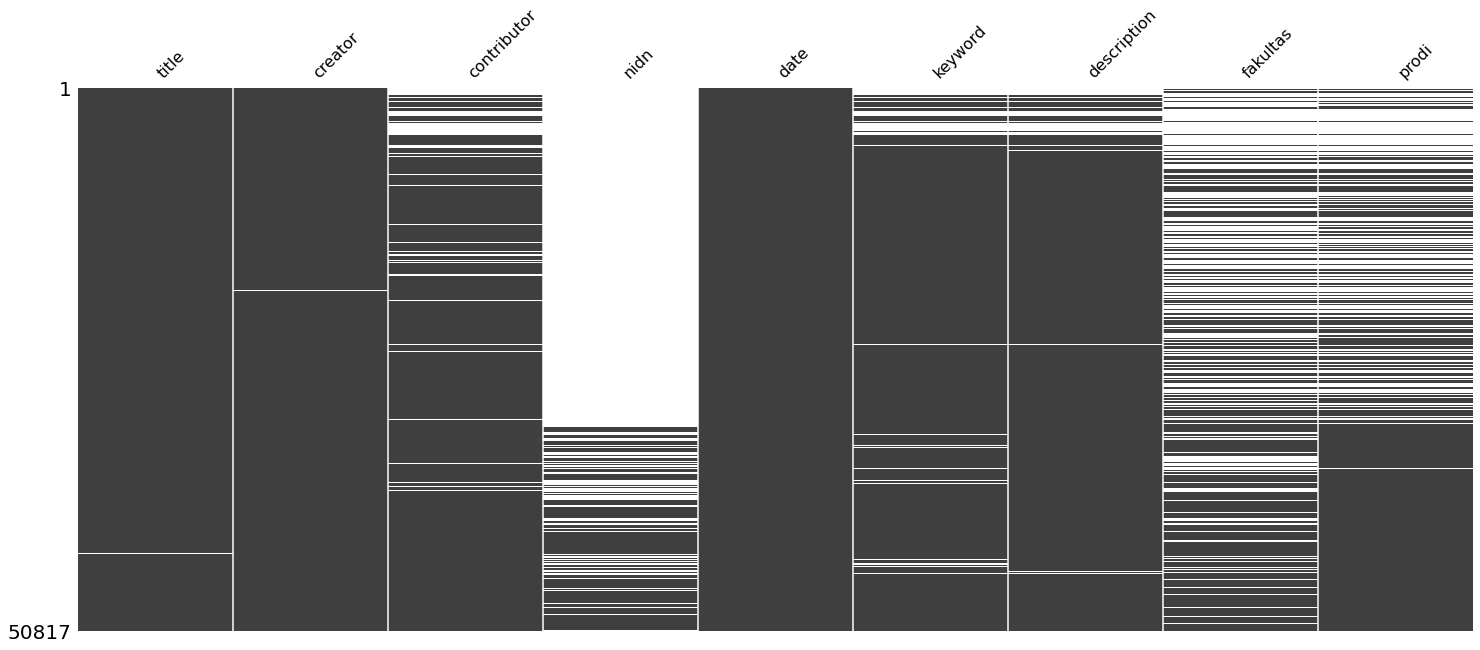

In [28]:
msno.matrix(data.replace('', np.nan),
            sparkline=False);